In [5]:
library(tidyverse)
library(rethinking)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: rstan

Loading required package: StanHeaders

rstan (Version 2.19.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: parallel

Loading required package: dagitty

rethinking (Version 1.93)


Attaching package: ‘rethinking’


The following object is masked from ‘

In [23]:
#import the data
data <- read.csv(file='/Users/timothymcmillan/Documents/IHI_projects/clotting/simulated_data2.csv')
data <- transform(data, result_date = as.Date(result_date))

When we run on the real data, we may have to change the datatypes:

winpath_master <- transform(winpath_master, result = as.character(result))
winpath_master <- transform(winpath_master, result = as.numeric(result))
winpath_master <- transform(winpath_master, age = as.character(age))
winpath_master <- transform(winpath_master, age = as.numeric(age))
winpath_master <- transform(winpath_master, result_date = as.Date(result_date))

# The Problem

## Do we order too many INR tests?

Anecdotally, INR is a blood test that is ordered relatively frequently during some patients' hospital admission. 

How many are we ordering? Do we order too many? If so, to what extent are we over-ordering? Is there anything that we guide when a blood test needs to be checked (or rather, doesn't need to be checked).

### How many INRs are we ordering?

In [7]:
count <- data %>%
    summarise(n())

count

n()
<int>
1259


In [ ]:
#this won't currently run as we do no have the source_category field. But the following
#is to check where out tests are being ordered from (IP vs OP vs AE)

#source_category <- data %>% 
#  group_by(source_category) %>% 
#  count(source_category, sort = TRUE, name="tests") %>% 
#  filter(tests > 1000)

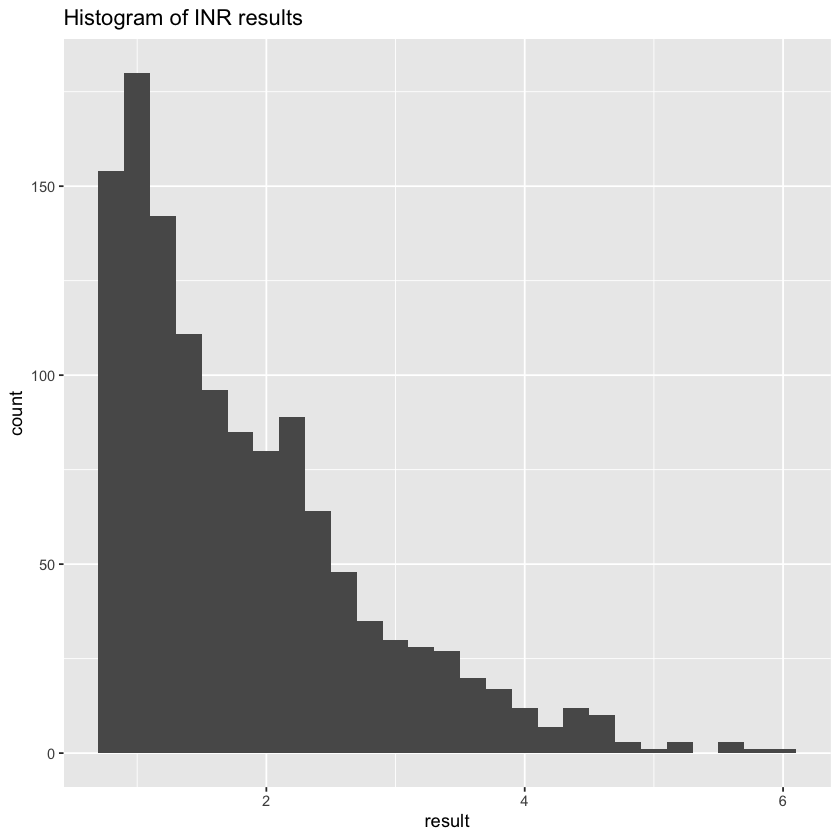

In [8]:
#by plotting the histogram of the INR results

ggplot(data, aes(x=result)) + 
geom_histogram(binwidth=0.2) +
ggtitle("Histogram of INR results")

more histograms to be added:

inr result by: age, location, gender

frequency of monitoring (number of days between each blood test)

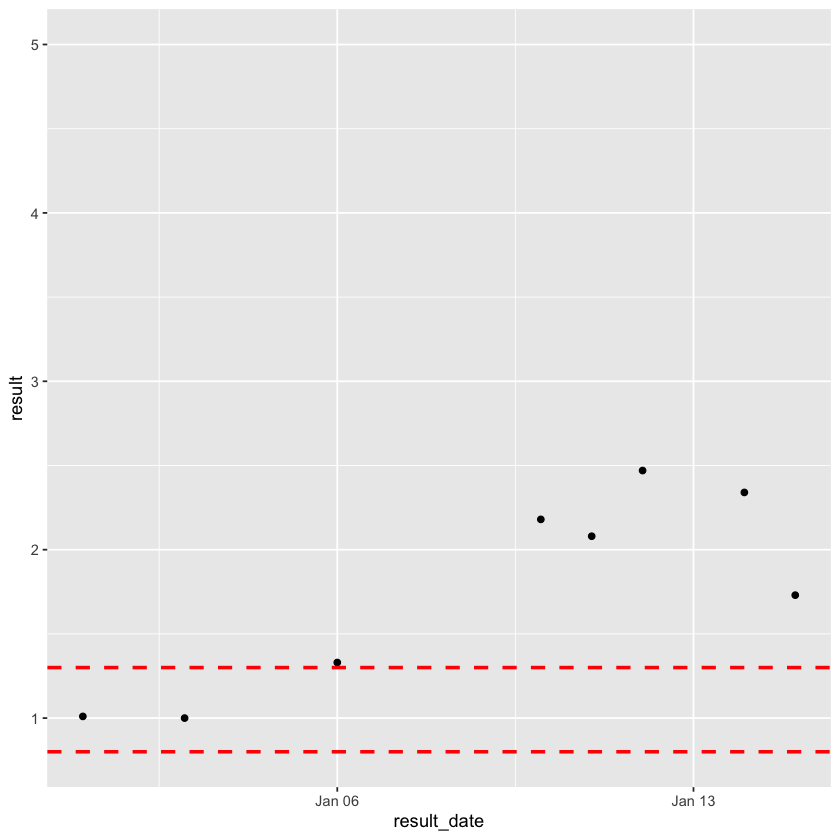

In [90]:
pt_no_1 <- data  %>% 
  filter(patient_number == 1)

ggplot(pt_no_1, aes(result_date, result))  + 
    geom_point() +
    scale_y_continuous(limits=c(0.8, 5.0)) +
    geom_hline(yintercept=0.8, size=1, colour="red", linetype="dashed") +
    geom_hline(yintercept=1.3, size=1, colour="red", linetype="dashed")

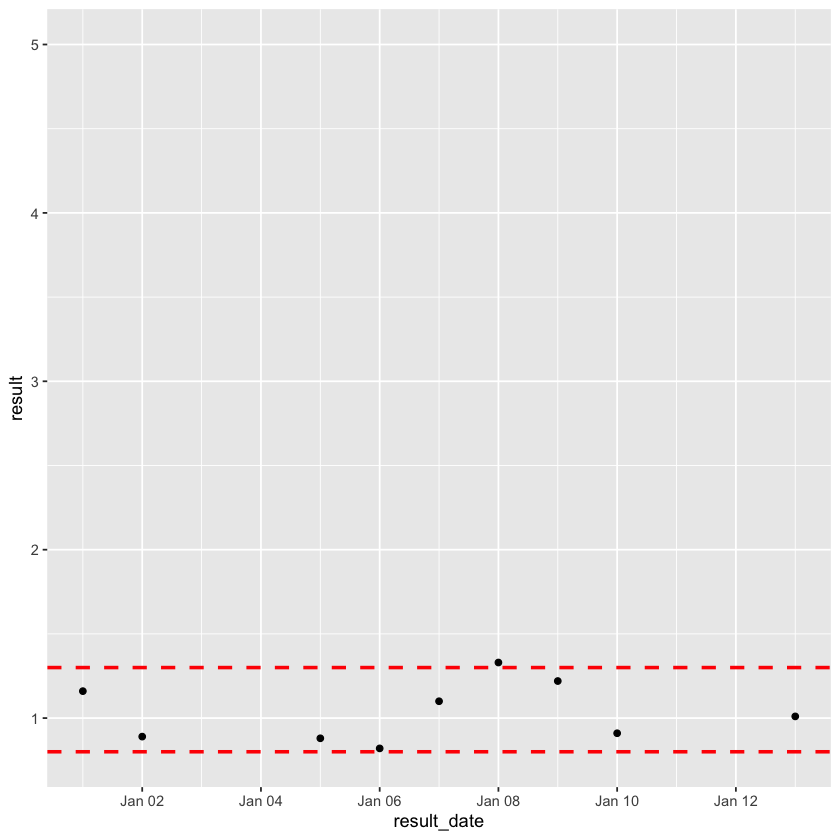

In [91]:
pt_no_3 <- data  %>% 
  filter(patient_number == 3)

ggplot(pt_no_3, aes(result_date, result))  + 
    geom_point() +
    scale_y_continuous(limits=c(0.8, 5.0)) +
    geom_hline(yintercept=0.8, size=1, colour="red", linetype="dashed") +
    geom_hline(yintercept=1.3, size=1, colour="red", linetype="dashed")

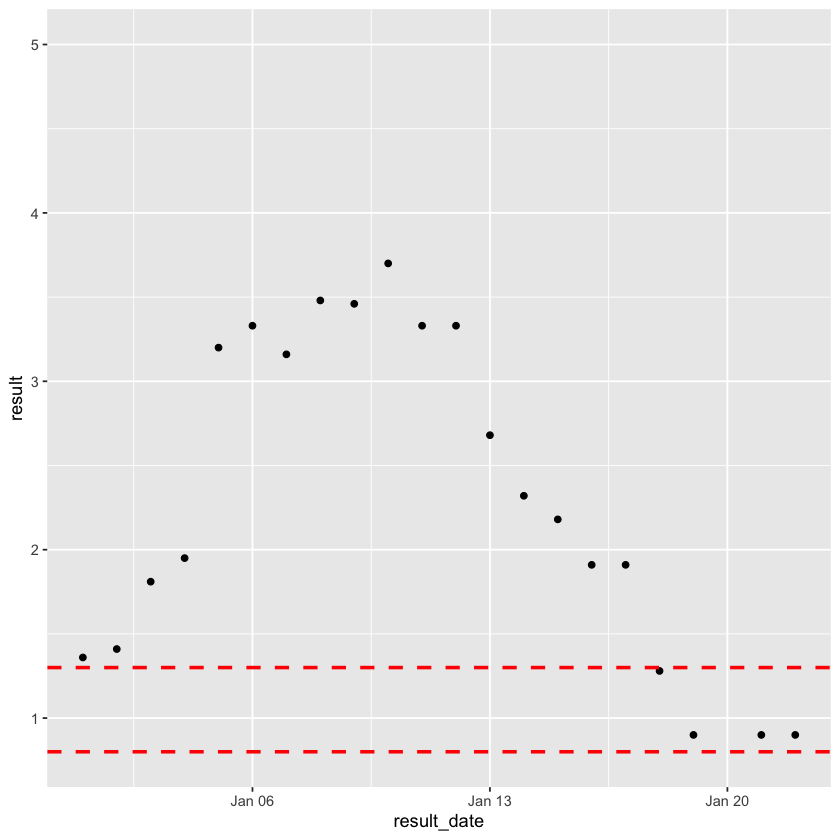

In [92]:
pt_no_4 <- data  %>% 
  filter(patient_number == 4)

ggplot(pt_no_4, aes(result_date, result))  + 
    geom_point() +
    scale_y_continuous(limits=c(0.8, 5.0)) +
    geom_hline(yintercept=0.8, size=1, colour="red", linetype="dashed") +
    geom_hline(yintercept=1.3, size=1, colour="red", linetype="dashed")

### Are we ordering too many?

In [101]:

#split the data into INR data and non-INR data
#we do this because we want to identify the repeated abnormal INRs, and the LFTs get in the wway otherwsiee

#this won't currently run on the synthetic data as we don't have lfts
#data_inr <- data %>%
#  filter(test_library_code == "COAT")

#data_lfts <- data %>%
#  filter(test_library_code == "LFT")

In [102]:
# create 2 flags. 1 patients who are having their inr checked for the 3rd time in 5 days and, 
# 2 those patients in which the 2 previous results were normal

data_inr <- data %>% 
  group_by(patient_number) %>%
  mutate(fivedays_prior_to_test = result_date -5) %>% 
  mutate(date_of_2tests_prior = lag(result_date, 2, order_by = result_date)) %>%
  mutate(flag_3rdtest_within5days = date_of_2tests_prior>=fivedays_prior_to_test) %>% 
  mutate(prv_inr_result = lag(result, 1, order_by = result_date)) %>% 
  mutate(prv_2nd_inr_result = lag(result, 2, order_by = result_date)) %>% 
  mutate(two_prv_normal_INR_flag = result<=1.3 & result>=0.8 & prv_inr_result <=1.3 & prv_inr_result>=0.8 & prv_2nd_inr_result <=1.3 & prv_2nd_inr_result>=0.8) %>% 
  mutate(two_prv_normal_within_5_days = flag_3rdtest_within5days & two_prv_normal_INR_flag) %>% 
  arrange(patient_number, result_date)

In [103]:
head(data_inr)

patient_number,gender,age,result_date,result,fivedays_prior_to_test,date_of_2tests_prior,flag_3rdtest_within5days,prv_inr_result,prv_2nd_inr_result,two_prv_normal_INR_flag,two_prv_normal_within_5_days
<int>,<fct>,<int>,<date>,<dbl>,<date>,<date>,<lgl>,<dbl>,<dbl>,<lgl>,<lgl>
1,F,50,2014-01-01,1.01,2013-12-27,NA,NA,NA,NA,NA,NA
1,F,50,2014-01-03,1.00,2013-12-29,NA,NA,1.01,NA,NA,NA
1,F,50,2014-01-06,1.33,2014-01-01,2014-01-01,TRUE,1.00,1.01,FALSE,FALSE
1,F,50,2014-01-10,2.18,2014-01-05,2014-01-03,FALSE,1.33,1.00,FALSE,FALSE
1,F,50,2014-01-11,2.08,2014-01-06,2014-01-06,TRUE,2.18,1.33,FALSE,FALSE
1,F,50,2014-01-12,2.47,2014-01-07,2014-01-10,TRUE,2.08,2.18,FALSE,FALSE


In [104]:
data_inr <- data_inr %>%
  select(-fivedays_prior_to_test, -date_of_2tests_prior, -flag_3rdtest_within5days, -prv_inr_result, -prv_2nd_inr_result, -two_prv_normal_INR_flag) %>% 
  ungroup() %>% 
  mutate(two_prv_normal_within_5_days = ifelse(is.na(two_prv_normal_within_5_days) | two_prv_normal_within_5_days == FALSE, FALSE, TRUE)) %>% 
  mutate(justified_test = !two_prv_normal_within_5_days)

In [105]:
inr_justified_false <- data_inr %>%
  filter(justified_test == FALSE)

# count the number of times both flags are true (3 normal inrs checked in 5 days)
pt_count_pot_avoid_test <- data_inr %>% 
  group_by(patient_number) %>% 
  filter(justified_test == FALSE) %>% 
  summarise(count_pot_avoid_test = n()) %>% 
  arrange(desc(count_pot_avoid_test))

In [106]:
#display the patients with repeatedly normal INRs
head(pt_count_pot_avoid_test)

patient_number,count_pot_avoid_test
<int>,<int>
56,17
75,16
10,15
12,15
34,10
47,10


In [107]:
# total number of instances there were 3 normal inrs checked within 5 days
sum(pt_normal_inr_rpt_counts$count_rpt_normals)

[1] 276

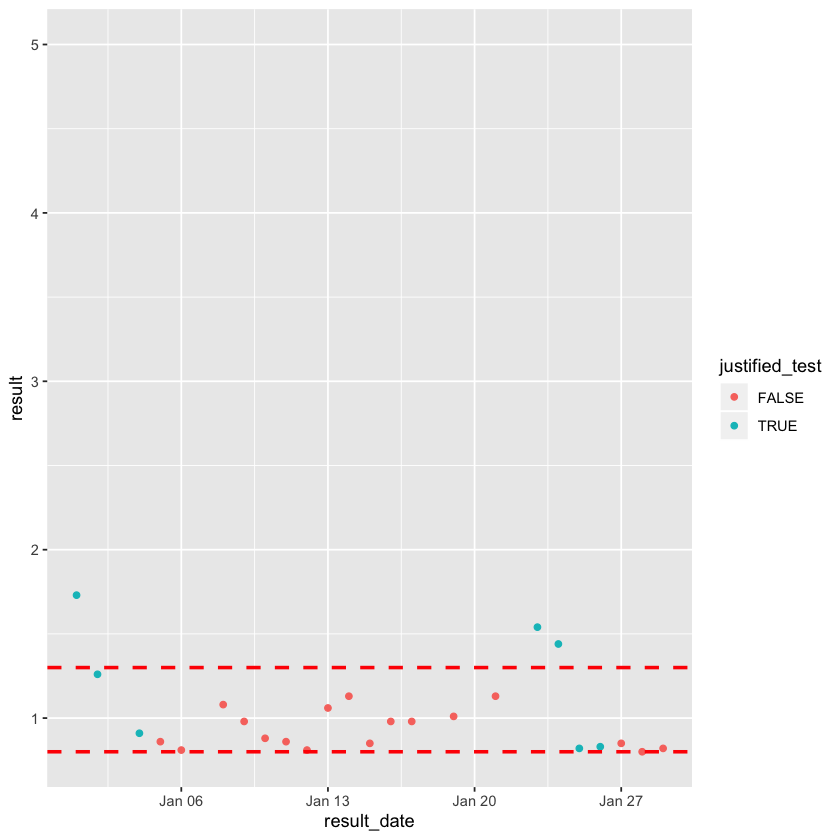

In [32]:
pt_no_56 <- data_inr  %>% 
  select(patient_number, result_date, result, justified_test) %>% 
  filter(patient_number == 56) %>%  
  arrange(result_date)

# plotting the time series of this patient's measurement
ggplot(pt_no_56,aes(result_date, result, color = justified_test)) + 
    geom_point() +
    scale_y_continuous(limits=c(0.8, 5.0)) +
    geom_hline(yintercept=0.8, size=1, colour="red", linetype="dashed") +
    geom_hline(yintercept=1.3, size=1, colour="red", linetype="dashed")

### Is there anything that we can do about it?

Let's start with a very simple rule: if the patients' 2 most-recent INR results have been normal (0.8-1.3), and within the past 5 days, skip the test.

Given that we have not done that blood test, remove this test from our results and re-analyse the subsequent blood tests. 

For example:


In [97]:
ex1 <- data.frame('date'=c('01/01/2019', '03/01/2019', '04/01/2019', '07/01/2019'), 
                  'result' = c(1.1, 1.1, 1.1, 1.1))
ex1

date,result
<fct>,<dbl>
01/01/2019,1.1
03/01/2019,1.1
04/01/2019,1.1
07/01/2019,1.1


In the data above, we would suggest that the test on 04/01/2019 was potentially unnecassary. (Since we the 2 most-recent results were normal, and done within the past 5 days).

So we remove this reading. 


In [98]:
ex1 <- ex1[-3,]
ex1

,date,result
,<fct>,<dbl>
1,01/01/2019,1.1
2,03/01/2019,1.1
4,07/01/2019,1.1


With this removed, we look at the reading from the 07/01/2019. We cannot remove this reading, as it does not meet our criteria for a potentially unnecessary blood test. 

In [74]:
i <- 1
j<-0

#list the unique patient_numbers within the dataset
patient_ids <- unique(data_inr$patient_number)

#we will split our tests into 2 dataframes which we initialise here. Tests which meet our
#removal criteria and those that don't.
removed_tests <- data.frame(matrix(ncol=15, nrow=0))
non_removed_tests <- data.frame(matrix(ncol=15, nrow=0))
colnames(removed_tests) <- colnames(data_inr)
colnames(non_removed_tests) <- colnames(data_inr)

#for each patient within our dataset
for (pt_id in 1:length(patient_ids)){
    
    #the number of tests this patient has had
    nrow_data <- nrow(data_inr[data_inr$patient_number == patient_ids[pt_id],])
    
    i <- 1
    j<-0
    
    # a dataframe of only this patient's results
    pt_inr_data <- data_inr %>%
        filter(patient_number == patient_ids[pt_id])
    
    #while we have not checked every row of the dataset
    while (i+j <nrow_data){
    
        #if the patient's test is justified, move on to the next row
  if(pt_inr_data[i, "justified_test"] == TRUE) {
    i <- i+1
  } 
        #if the test has been flagged as not justified, remove this from the dataset, and 
        #add it to the "removed_tests" dataset
        
        else {
      removed_tests <- rbind(removed_tests,pt_inr_data[i,])
      pt_inr_data <- pt_inr_data[-i,]
      
            #with the test removed, this affects whether the downstream tests were justified or
            #not. So we re-run our code to identify potentially avoidable tests (this is the 
            #same code we used previously)
      pt_inr_data <- pt_inr_data %>% 
        group_by(patient_number) %>%
        mutate(fivedays_prior_to_test = result_date -5) %>% 
        mutate(date_of_2tests_prior = lag(result_date, 2, order_by = result_date)) %>%
        mutate(flag_3rdtest_within5days = date_of_2tests_prior>=fivedays_prior_to_test) %>% 
        mutate(prv_inr_result = lag(result, 1, order_by = result_date)) %>% 
        mutate(prv_2nd_inr_result = lag(result, 2, order_by = result_date)) %>% 
        mutate(two_prv_normal_INR_flag = prv_inr_result <=1.3 & prv_inr_result>=0.8 & prv_2nd_inr_result <=1.3 & prv_2nd_inr_result>=0.8) %>% 
        mutate(two_prv_normal_within_5_days = flag_3rdtest_within5days & two_prv_normal_INR_flag) %>% 
        arrange(patient_number, result_date)
      
      pt_inr_data <- pt_inr_data %>%
        select(-fivedays_prior_to_test, -date_of_2tests_prior, -flag_3rdtest_within5days, -prv_inr_result, -prv_2nd_inr_result, -two_prv_normal_INR_flag) %>% 
        ungroup() %>% 
        mutate(two_prv_normal_within_5_days = ifelse(is.na(two_prv_normal_within_5_days) | two_prv_normal_within_5_days == FALSE, FALSE, TRUE)) %>% 
        mutate(justified_test = !two_prv_normal_within_5_days)
    
      j <- j+1 
      
      }
        

}
            #by the end of the loop, the pt_inr_data dataframe only contains non-removed tests
             non_removed_tests <- rbind(non_removed_tests,pt_inr_data)
}


In [79]:
nrow(removed_tests) + nrow(non_removed_tests)

[1] 1259

In [78]:
nrow(data_inr)

[1] 1259

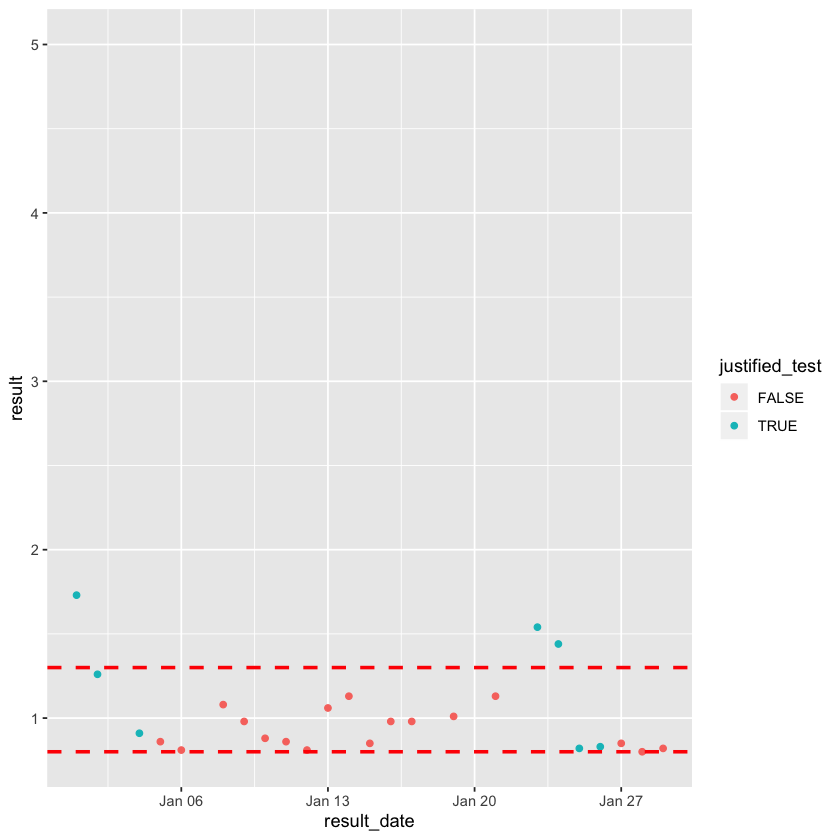

In [80]:
pt_no_56 <- data_inr  %>% 
  select(patient_number, result_date, result, justified_test) %>% 
  filter(patient_number == 56) %>%  
  arrange(result_date)

# plotting the time series of this patient's measurement
ggplot(pt_no_56,aes(result_date, result, color = justified_test)) + 
    geom_point() +
    scale_y_continuous(limits=c(0.8, 5.0)) +
    geom_hline(yintercept=0.8, size=1, colour="red", linetype="dashed") +
    geom_hline(yintercept=1.3, size=1, colour="red", linetype="dashed")

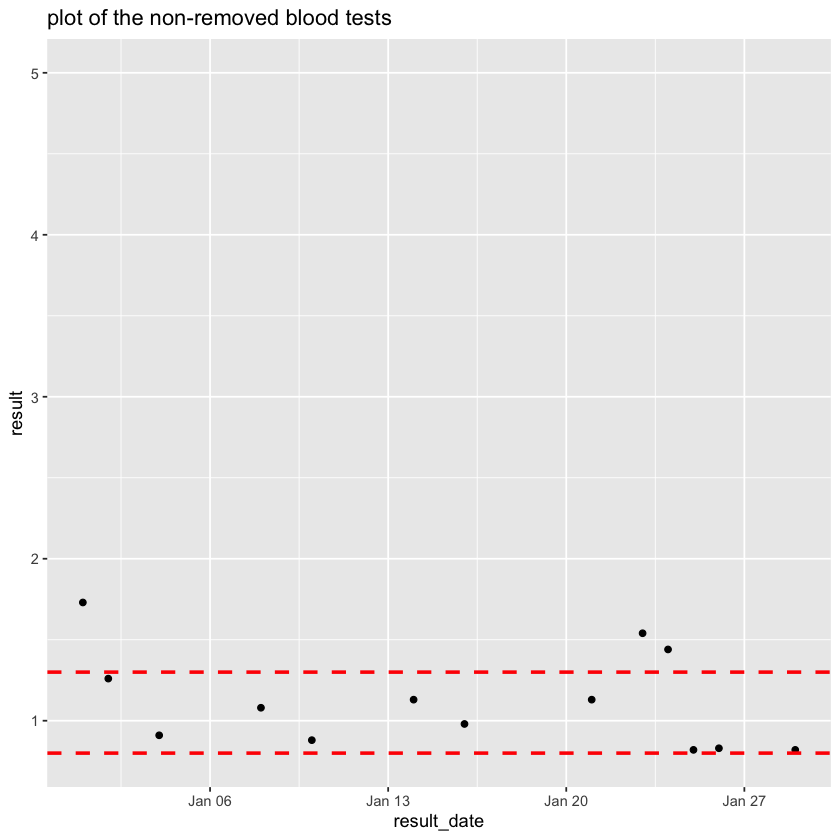

In [100]:
pt_no_56_nonremoved <- non_removed_tests  %>% 
  select(patient_number, result_date, result, justified_test) %>% 
  filter(patient_number == 56) %>%  
  arrange(result_date)

# plotting the time series of this patient's measurement
ggplot(pt_no_56_nonremoved,aes(result_date, result)) + 
    geom_point() +
    scale_y_continuous(limits=c(0.8, 5.0)) +
    geom_hline(yintercept=0.8, size=1, colour="red", linetype="dashed") +
    geom_hline(yintercept=1.3, size=1, colour="red", linetype="dashed") +
    ggtitle("plot of the non-removed blood tests")

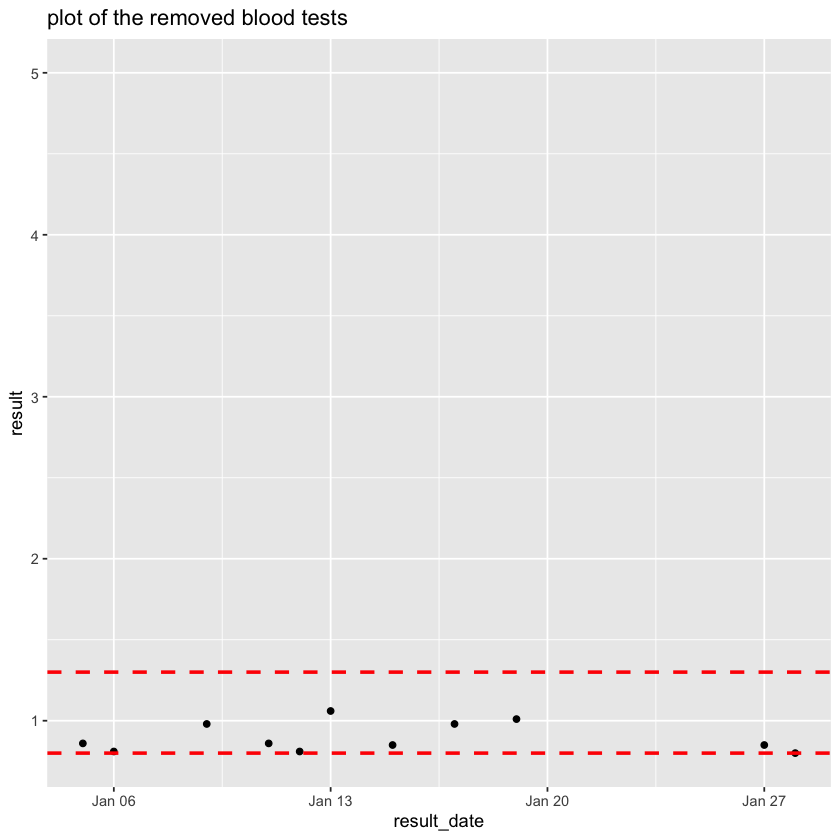

In [86]:
pt_no_56_removed <- removed_tests  %>% 
  select(patient_number, result_date, result, justified_test) %>% 
  filter(patient_number == 56) %>%  
  arrange(result_date)

# plotting the time series of this patient's measurement
ggplot(pt_no_56_removed,aes(result_date, result)) + 
    geom_point() +
    scale_y_continuous(limits=c(0.8, 5.0)) +
    geom_hline(yintercept=0.8, size=1, colour="red", linetype="dashed") +
    geom_hline(yintercept=1.3, size=1, colour="red", linetype="dashed") +
    ggtitle('plot of the removed blood tests')

But what about the values of the INRs that we have suggested not doing? Would we have missed any abnormal INRs?

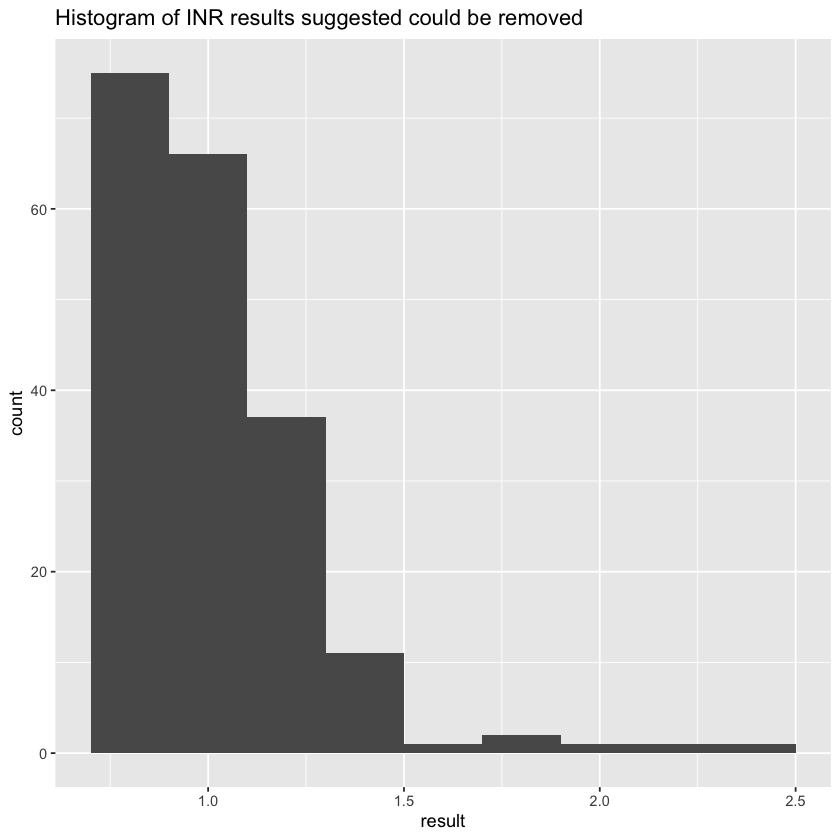

In [87]:
ggplot(removed_tests, aes(x=result)) + 
geom_histogram(binwidth=0.2) +
ggtitle("Histogram of INR results suggested could be removed")

what percentage of tests that we suggested could be removed were abnormal (<0.8 or >1.3)?


In [89]:
sum((removed_tests$result >1.3 | removed_tests$result <0.8))/nrow(removed_tests)

[1] 0.08717949

8.7% of our suggested removed tests were abnormal

### can we be a bit more precise than this?
model

In [12]:
head(data)

patient_number,gender,age,result_date,result,prev_rslt_1,prev_rslt_1_date,days_since_test_1,rslt_diff_1
<int>,<fct>,<int>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
1,F,50,2014-01-01,1.01,NA,NA,NA,NA
1,F,50,2014-01-03,1.00,1.01,2014-01-01,2,-0.01
1,F,50,2014-01-06,1.33,1.00,2014-01-03,3,0.33
1,F,50,2014-01-10,2.18,1.33,2014-01-06,4,0.85
1,F,50,2014-01-11,2.08,2.18,2014-01-10,1,-0.10
1,F,50,2014-01-12,2.47,2.08,2014-01-11,1,0.39


add 2 columns to the dataframe:
- first is the result previous to this one
- second is how many days prior that result was

In [13]:
data <- data %>%
    group_by(patient_number) %>%
    mutate(prev_rslt_1 = lag(result, 1, order_by = result_date)) %>%
    mutate(prev_rslt_1_date = lag(result_date, 1, order_by = result_date)) %>%
    arrange(patient_number, result_date)

insert a column calculating the days lapsed between the 2 results.

In [14]:
data <- data %>%
    mutate(days_since_test_1 = as.numeric(difftime(result_date, prev_rslt_1_date)))

insert a column calculating the difference between the current INR result and the one prior to that

In [15]:
data <- data %>%
    mutate(rslt_diff_1 = result - prev_rslt_1)

In [17]:
data <- data %>%
    select(-prev_rslt_1_date) %>%
    ungroup()

In [18]:
head(data)

patient_number,gender,age,result_date,result,prev_rslt_1,days_since_test_1,rslt_diff_1
<int>,<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,F,50,2014-01-01,1.01,NA,NA,NA
1,F,50,2014-01-03,1.00,1.01,2,-0.01
1,F,50,2014-01-06,1.33,1.00,3,0.33
1,F,50,2014-01-10,2.18,1.33,4,0.85
1,F,50,2014-01-11,2.08,2.18,1,-0.10
1,F,50,2014-01-12,2.47,2.08,1,0.39


Warning message:
“Removed 100 rows containing non-finite values (stat_bin).”


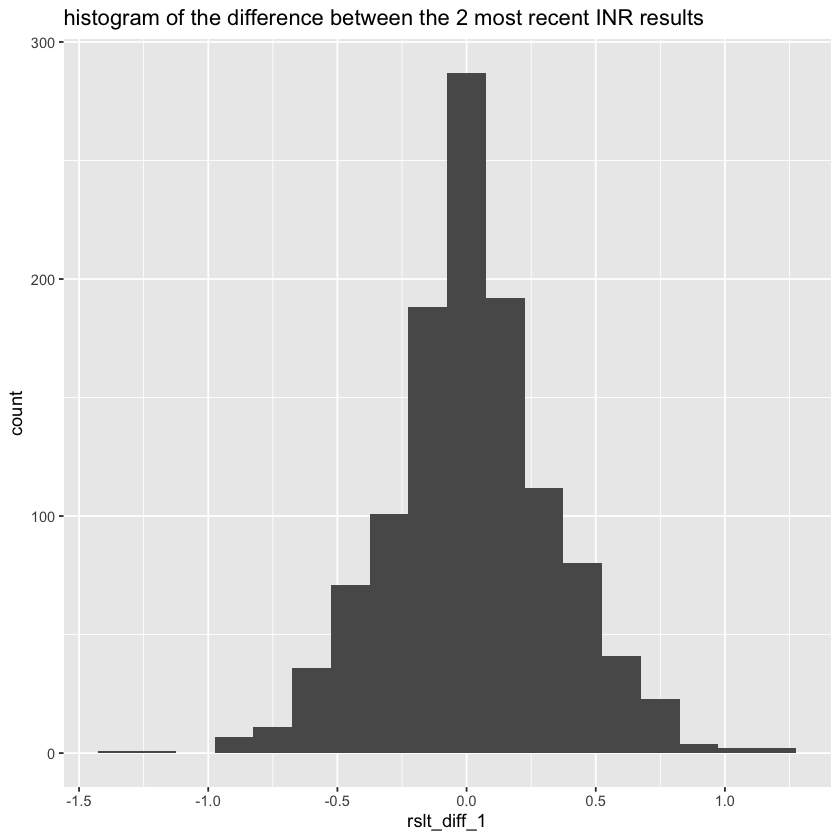

In [27]:
#plot a histogram of the difference between the current INR and the most recent one

ggplot(data, aes(x=rslt_diff_1))+
geom_histogram(binwidth=0.15) +
ggtitle("histogram of the difference between the 2 most recent INR results")

Warning message:
“Removed 100 rows containing missing values (geom_point).”


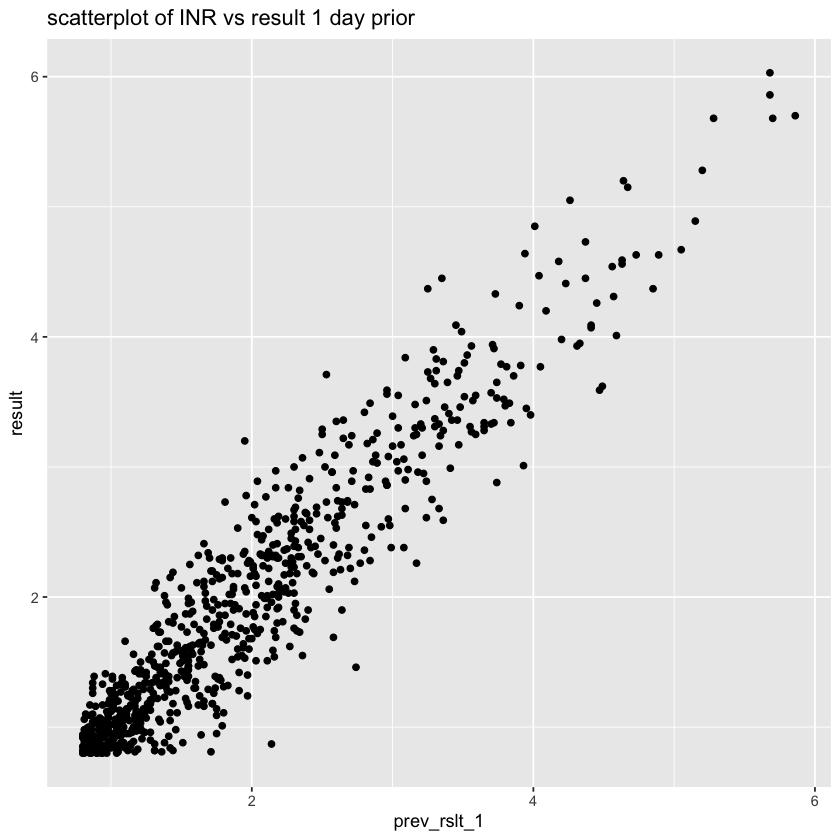

In [28]:
data_freq_1 <- data[data$days_since_test_1==1,]

ggplot(data_freq_1, aes(x=prev_rslt_1, y=result)) + 
geom_point() +
ggtitle("scatterplot of INR vs result 1 day prior")

A few sample patients

## simple model to predict tests - version 1

The following patients had their inr measured yesterday. The results were c(1.1, 1.3, 2.2, 1.7). What do we estimate their INR is today?

In [38]:
data_freq_1 <- data_freq_1 %>%
    filter(is.na(patient_number)==FALSE)

head(data_freq_1)


patient_number,gender,age,result_date,result,prev_rslt_1,days_since_test_1,rslt_diff_1
<int>,<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,F,50,2014-01-11,2.08,2.18,1,-0.10
1,F,50,2014-01-12,2.47,2.08,1,0.39
1,F,50,2014-01-15,1.73,2.34,1,-0.61
2,F,79,2014-01-04,2.48,2.04,1,0.44
2,F,79,2014-01-05,3.11,2.48,1,0.63
2,F,79,2014-01-06,2.98,3.11,1,-0.13


define our model:

result ~ Normal(mu, sigma) 

#note that the INRs are not distributed normally, so this may not be the best choice

mu = alpha + beta*prev_rslt_1
#the mean of today's INR possible values is equal to the alpha plus beta*yesterday's INR result

alpha ~ Normal(1.2, 2)
#alpha is distributed normally, with mean 1.2 and sd 0.4

beta ~ lognorm(0,1)
#we suspect that the relationship between today's INR and yesterday's INR will be positive. Therefore we define beta to be distributed as lognorm(0,1)

sigma ~ uniform(0,5)
#lets say we know very little about sigma


In [39]:
flist<- alist(
    result ~ dnorm(mu, sigma),
    mu <- alpha + beta*prev_rslt_1,
    alpha <- dnorm(1.2, 2),
    beta <- dlnorm(0,1),
    sigma <- dunif(0,50)
    )

m_1 <- quap(flist, data=data_freq_1)

In [40]:
inr.sequence <- seq(from=0.8, to = 7, by=0.05)

#sample from mu using link
mu <- link(m_1, data=data.frame(prev_rslt_1=inr.sequence))
mu.HPDI <- apply(mu, 2, HPDI, prob=0.89)

result <- sim(m_1, data=data.frame(prev_rslt_1=inr.sequence))
result.HPDI <- apply(result, 2, HPDI, prob=0.89)



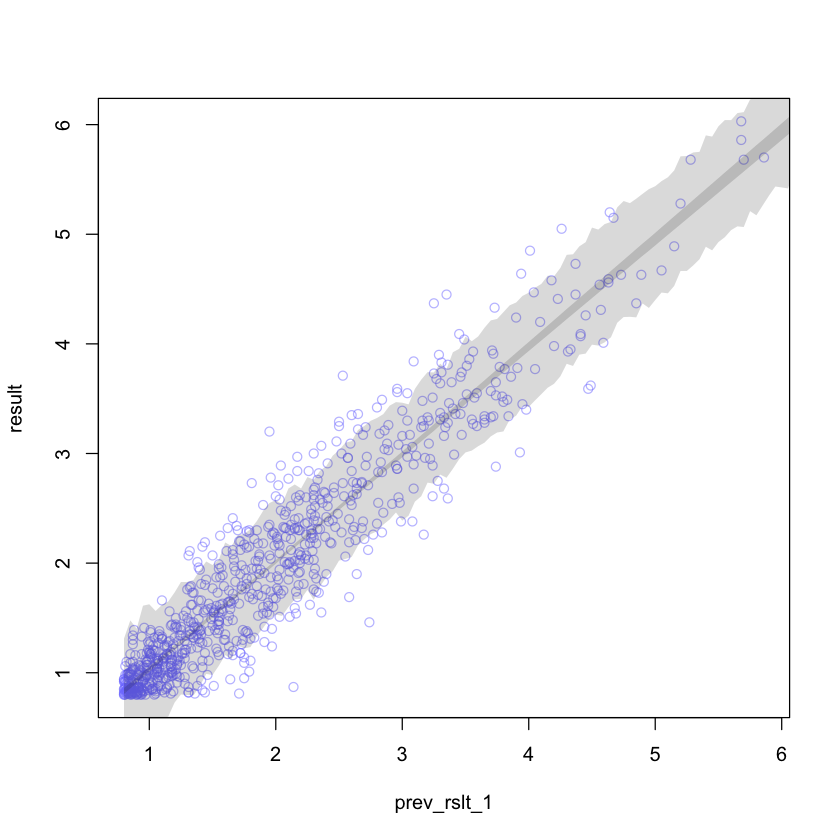

In [41]:
plot(result ~ prev_rslt_1, data=data_freq_1, col=col.alpha(rangi2, 0.5))
shade(mu.HPDI, inr.sequence)
shade(result.HPDI, inr.sequence)


In [42]:
# repeat the above using the values that we have been given for yesterday's results: c(1.1, 1.3, 2.2, 1.7)

inr_yesterday <- c(1.1, 1.3, 2.2, 1.7)

#sample from mu using link
mu <- link(m_1, data=data.frame(prev_rslt_1=inr_yesterday))
mu.HPDI <- apply(mu, 2, HPDI, prob=0.89)

result <- sim(m_1, data=data.frame(prev_rslt_1=inr_yesterday))
result.HPDI <- apply(result, 2, HPDI, prob=0.89)


In [43]:
estimates <- data.frame(rbind(mu.HPDI, result.HPDI))
colnames(estimates) <- inr_yesterday
rownames(estimates) <- c("mu_lower", "mu_upper", "result_lower", "result_upper")
estimates

,1.1,1.3,2.2,1.7
,<dbl>,<dbl>,<dbl>,<dbl>
mu_lower,1.1057658,1.3042632,2.191124,1.699150
mu_upper,1.1526931,1.3473411,2.228110,1.736124
result_lower,0.6278161,0.8137938,1.697949,1.210823
result_upper,1.6901147,1.8963021,2.757566,2.281305


## Next steps

Evaluate the modelv1 above

introduce more parameters: days since test, LFTs, age, locations